In [1]:
#Library
import random
import math
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.transforms as T
import time
import torch.nn as nn
from torchvision.utils import make_grid
import os
import requests
import matplotlib.pyplot as plt
import warnings
warnings.warn("ignore")
from torchvision import transforms

/var/folders/8x/1t17t31j0tz9cs952kyj6xf80000gp/T/ipykernel_43911/3792874269.py:19: UserWarning: ignore
  warnings.warn("ignore")


In [2]:
class MyRegex:
    def search(self, pattern, text):
        # Implementasi pencarian pola dalam sebuah teks
        for i in range(len(text)):
            if text[i:i + len(pattern)] == pattern:
                return text[i:i + len(pattern)]
        return None

    def match(self, pattern, text):
        # Implementasi pencocokan pola hanya di awal teks
        if text.startswith(pattern):
            return pattern
        return None

    def findall(self, pattern, text):
        # Implementasi pencarian semua kemunculan pola dalam teks
        matches = []
        i = 0
        while i < len(text):
            match = self.match(pattern, text[i:])
            if match:
                matches.append(match)
                i += len(match)
            else:
                i += 1
        return matches

    def sub(self, pattern, replacement, text):
        # Implementasi penggantian pola dengan teks lain
        result = ""
        while True:
            match = self.search(pattern, text)
            if match:
                result += text[:text.index(match)] + replacement
                text = text[text.index(match) + len(match):]
            else:
                result += text
                break
        return result

In [3]:
class MyTqdm:
    def __init__(self, iterable, total=None, desc='', bar_length=40):
        self.iterable = iterable
        self.total = len(iterable) if total is None else total
        self.desc = desc
        self.bar_length = bar_length
        self.start_time = time.time()

    def __iter__(self):
        return self._generate()

    def _format_time(self, seconds):
        minutes, seconds = divmod(int(seconds), 60)
        hours, minutes = divmod(minutes, 60)
        return f'{hours:02}:{minutes:02}:{seconds:02}'

    def _progress_bar(self, iteration):
        progress = int(self.bar_length * iteration / max(self.total, 1))  # Handle division by 0
        return f"[{'=' * progress}{' ' * (self.bar_length - progress)}]"

    def _generate(self):
        print(f"{self.desc}: 0% {self._progress_bar(0)} 00:00:00", end='', flush=True)

        for i, item in enumerate(self.iterable, 1):
            yield item
            if i % (max(self.total // self.bar_length, 1)) == 0 or i == self.total:  # Handle division by 0
                elapsed_time = time.time() - self.start_time
                percentage = i / max(self.total, 1) * 100  # Handle division by 0
                remaining_time = (elapsed_time / max(i, 1)) * (max(self.total - i, 1))  # Handle division by 0
                print(f"\r{self.desc}: {percentage:.1f}% {self._progress_bar(i)} {self._format_time(elapsed_time)} / ETA {self._format_time(remaining_time)}", end='', flush=True)

        print("\n")

In [4]:
#Creating OS for Operating System Directory File
class MyOS:
    def __init__(self):
        self.current_directory = os.getcwd()

    def getcwd(self):
        return self.current_directory

    def chdir(self, path):
        if os.path.exists(path) and os.path.isdir(path):
            self.current_directory = path
        else:
            raise FileNotFoundError("Direktori tidak ditemukan.")

    def listdir(self, path='.'):
        full_path = os.path.join(self.current_directory, path)
        if os.path.exists(full_path) and os.path.isdir(full_path):
            return os.listdir(full_path)
        else:
            raise FileNotFoundError("Direktori tidak ditemukan.")

    def mkdir(self, path):
        full_path = os.path.join(self.current_directory, path)
        if not os.path.exists(full_path):
            os.mkdir(full_path)
        else:
            raise FileExistsError("Direktori sudah ada.")

    def rename(self, old, new):
        old_path = os.path.join(self.current_directory, old)
        new_path = os.path.join(self.current_directory, new)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)
        else:
            raise FileNotFoundError("Path lama tidak ditemukan.")

    def remove(self, path):
        full_path = os.path.join(self.current_directory, path)
        if os.path.exists(full_path):
            os.remove(full_path)
        else:
            raise FileNotFoundError("Path tidak ditemukan.")

    def rmdir(self, path):
        full_path = os.path.join(self.current_directory, path)
        if os.path.exists(full_path) and os.path.isdir(full_path):
            os.rmdir(full_path)
        else:
            raise FileNotFoundError("Direktori tidak ditemukan atau bukan direktori kosong.")

    def exists(self, path):
        full_path = os.path.join(self.current_directory, path)
        return os.path.exists(full_path)

    def isfile(self, path):
        full_path = os.path.join(self.current_directory, path)
        return os.path.isfile(full_path)

    def isdir(self, path):
        full_path = os.path.join(self.current_directory, path)
        return os.path.isdir(full_path)

In [16]:
#Calling Dataset
data_directory = 'Face Recognition'
my_os = MyOS()

In [17]:
try:
    file_list = my_os.listdir(data_directory)
    print(file_list)
except FileNotFoundError as e:
    print(e)

['Chen', 'Rendie', 'Nicho', 'Alvian']


In [18]:
def get_path_names(dir):
    images=[]
    for path, subdir, files in os.walk(data_directory):
        for name in files:
            images.append(os.path.join(path, name))
    return images

In [19]:
path = get_path_names(data_directory)

In [20]:
def get_path_names(root_dir):
    images=[]
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                label = os.path.basename(root)
                images.append((image_path, label))
    return images

In [21]:
path[:3]

['Face Recognition/Chen/63.jpg',
 'Face Recognition/Chen/189.jpg',
 'Face Recognition/Chen/77.jpg']

In [22]:
classes = ['Alvian','Chen','Nicho','Rendie']

In [23]:
def encode_label(label, classes_list):
    if not isinstance(label, list):
        label = [label]
    target = torch.zeros(len(classes_list))
    for l in label:
        if l in classes_list:
            idx = classes_list.index(l)
            target[idx] = 1
    return target


def decode_target(target, threshold=0.5):
    if isinstance(target, list):
        result = ""
        for x in target:
            try:
                value = float(x)
                if value >= threshold:
                    result += "1"
                else:
                    result += "0"
            except ValueError:
                result += x
        return result
    else:
        try:
            value = float(target)
            if value >= threshold:
                return "1"
            else:
                return "0"
        except ValueError:
            return target

In [24]:
def get_classes(root_dir):
    classes = []
    for subdir in os.listdir(root_dir):
        if os.path.isdir(os.path.join(root_dir, subdir)):
            classes.append(subdir)
    return classes

In [25]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)
        self.classes = get_classes(root_dir)  # Get the list of class labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path)
        img = self.transform(img)

        print(f"Image Path: {img_path}")
        print(f"Label: {label}")

        return img, encode_label(label, classes_list=self.classes)

In [26]:
dataset = myDataset(root_dir = data_directory, transform=transforms.ToTensor())
len(dataset)

953

In [27]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform= transforms.Compose([T.Resize(128),
                      T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [28]:
dataset = myDataset(data_directory, transform = transform)
len(dataset)

953

In [29]:
dataset[5]

Image Path: Face Recognition/Chen/88.jpg
Label: Chen


(tensor([[[ 1.7694,  1.7694,  1.7694,  ...,  1.4098,  1.4098,  1.3927],
          [ 1.7865,  1.7865,  1.7865,  ...,  1.4269,  1.4269,  1.4269],
          [ 1.8208,  1.8208,  1.8208,  ...,  1.4783,  1.4440,  1.4612],
          ...,
          [ 1.5810,  1.5810,  1.5810,  ..., -1.2617, -1.1075, -0.9877],
          [ 1.5982,  1.6153,  1.6153,  ..., -1.2959, -1.2103, -1.0904],
          [ 1.5639,  1.6153,  1.6324,  ..., -1.2959, -1.2103, -1.0904]],
 
         [[ 1.8683,  1.8683,  1.8683,  ...,  1.4482,  1.4482,  1.4307],
          [ 1.8859,  1.8859,  1.8859,  ...,  1.4657,  1.4657,  1.4657],
          [ 1.9209,  1.9209,  1.9209,  ...,  1.5182,  1.4832,  1.5007],
          ...,
          [ 0.8704,  0.9405,  1.0105,  ..., -1.0903, -0.9678, -0.8627],
          [ 0.9055,  0.9405,  0.9580,  ..., -1.1078, -1.0553, -0.9678],
          [ 0.8704,  0.9055,  0.9055,  ..., -1.0903, -1.0553, -0.9678]],
 
         [[ 1.8905,  1.8905,  1.8905,  ...,  1.4897,  1.4897,  1.4722],
          [ 1.9080,  1.9080,

Image Path: Face Recognition/Nicho/145.jpg
Label: Nicho
Label: tensor([0., 0., 1., 0.])

tensor([0., 0., 1., 0.])


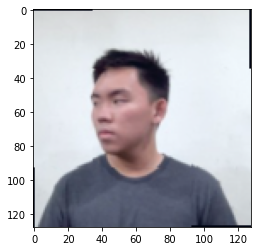

In [30]:
def denormalize(img_tensors): #Denormalize Image tensors
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_examples(img, label):
    plt.imshow(denormalize(img).permute(1, 2, 0))
    print("Label:", decode_target(label))
    print()
    print(label)

show_examples(*dataset[655]) #mengambil contoh gambar yang sudah di tensor


In [31]:
validation_percent = int(0.10 *len(dataset))
train_size = len(dataset) - validation_percent
validation_size = len(dataset) - train_size
train_size, validation_size

(858, 95)

In [32]:
train_datasplit, validation_datasplit = random_split(dataset, [train_size, validation_size]) #splitting the dataset for training and validation.
len(train_datasplit), len(validation_datasplit)

(858, 95)

In [33]:
batch_size = 64
train_loader = DataLoader(train_datasplit, batch_size, shuffle=True)
validation_loader = DataLoader(validation_datasplit, batch_size * 2)

In [34]:
for xb, yb in train_loader:
    print(xb.shape)
    print(yb.shape)
    break

Image Path: Face Recognition/Alvian/169.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/224.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/7.jpg
Label: Rendie
Image Path: Face Recognition/Chen/1.jpg
Label: Chen
Image Path: Face Recognition/Alvian/103.jpg
Label: Alvian
Image Path: Face Recognition/Chen/116.jpg
Label: Chen
Image Path: Face Recognition/Rendie/137.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/85.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/167.jpg
Label: Nicho
Image Path: Face Recognition/Rendie/131.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/86.jpg
Label: Alvian
Image Path: Face Recognition/Chen/119.jpg
Label: Chen
Image Path: Face Recognition/Alvian/91.jpg
Label: Alvian
Image Path: Face Recognition/Chen/149.jpg
Label: Chen
Image Path: Face Recognition/Nicho/106.jpg
Label: Nicho
Image Path: Face Recognition/Rendie/31.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/18.jpg
Label: Rendie
Image Path: Face Recognition/Chen/17.jpg
La

Image Path: Face Recognition/Rendie/236.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/18.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/67.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/242.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/123.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/217.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/69.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/137.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/249.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/160.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/37.jpg
Label: Rendie
Image Path: Face Recognition/Chen/180.jpg
Label: Chen
Image Path: Face Recognition/Rendie/189.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/92.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/220.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/33.jpg
Label: Alvian
Image Path: Face Recognition/Nicho/51.jpg
Label: Nicho
Image Path: Face Recognitio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


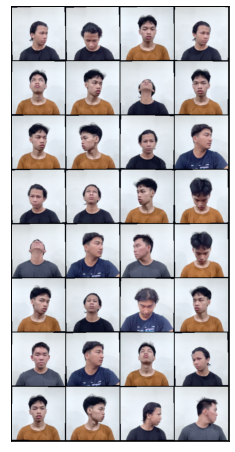

In [35]:
def show_batch_images(data, nmax=32):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(denormalize(images[:nmax]), nrow=4).permute(1, 2, 0))
        break

show_batch_images(train_loader)

In [36]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [37]:

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}"
              .format(epoch,
                      result['lrs'][-1],
                      result['train_loss'],
                      result['val_loss'],
                      result['val_score']))

In [38]:
# Fungsi untuk melakukan proses pada GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [39]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [40]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(validation_loader, device)

In [41]:
for xb, yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    break

Image Path: Face Recognition/Chen/194.jpg
Label: Chen
Image Path: Face Recognition/Alvian/172.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/230.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/54.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/17.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/24.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/68.jpg
Label: Alvian
Image Path: Face Recognition/Nicho/101.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/140.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/93.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/13.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/193.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/90.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/74.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/110.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/30.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/81.jpg
Label: Nicho
Image Path: Face Recognition/Chen/60.jpg
L

Image Path: Face Recognition/Nicho/147.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/46.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/136.jpg
Label: Alvian
Image Path: Face Recognition/Chen/17.jpg
Label: Chen
Image Path: Face Recognition/Rendie/37.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/141.jpg
Label: Alvian
Image Path: Face Recognition/Chen/199.jpg
Label: Chen
Image Path: Face Recognition/Chen/189.jpg
Label: Chen
Image Path: Face Recognition/Alvian/54.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/181.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/170.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/124.jpg
Label: Alvian
Image Path: Face Recognition/Chen/111.jpg
Label: Chen
Image Path: Face Recognition/Chen/157.jpg
Label: Chen
Image Path: Face Recognition/Rendie/57.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/11.jpg
Label: Alvian
Image Path: Face Recognition/Chen/139.jpg
Label: Chen
Image Path: Face Recognition/Chen/130.jpg
Label:

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in MyTqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2


        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 11

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [44]:
model = to_device(ResNet15(3, len(classes)), device) #input size: 3, output size: 11, loading model onto GPU
model

ResNet15(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fa

In [45]:
import torch.nn.functional as F

In [46]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Image Path: Face Recognition/Chen/200.jpg
Label: Chen
Image Path: Face Recognition/Rendie/63.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/157.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/155.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/175.jpg
Label: Alvian
Image Path: Face Recognition/Chen/54.jpg
Label: Chen
Image Path: Face Recognition/Nicho/215.jpg
Label: Nicho
Image Path: Face Recognition/Rendie/115.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/259.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/230.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/123.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/169.jpg
Label: Alvian
Image Path: Face Recognition/Chen/132.jpg
Label: Chen
Image Path: Face Recognition/Chen/150.jpg
Label: Chen
Image Path: Face Recognition/Nicho/108.jpg
Label: Nicho
Image Path: Face Recognition/Chen/55.jpg
Label: Chen
Image Path: Face Recognition/Alvian/84.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/11.jpg

In [47]:
history = [evaluate(model, val_dl)]
history

Image Path: Face Recognition/Alvian/122.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/138.jpg
Label: Alvian
Image Path: Face Recognition/Chen/88.jpg
Label: Chen
Image Path: Face Recognition/Rendie/0.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/248.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/184.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/255.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/10.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/134.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/91.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/104.jpg
Label: Nicho
Image Path: Face Recognition/Chen/22.jpg
Label: Chen
Image Path: Face Recognition/Rendie/6.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/2.jpg
Label: Rendie
Image Path: Face Recognition/Nicho/107.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/50.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/174.jpg
Label: Alvian
Image Path: Face Recognition/Rendie/2

[{'val_loss': 0.6906380653381348, 'val_score': 0.29219600558280945}]

In [48]:
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [49]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

: 0% [                                        ] 00:00:00Image Path: Face Recognition/Nicho/51.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/191.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/89.jpg
Label: Nicho
Image Path: Face Recognition/Rendie/49.jpg
Label: Rendie
Image Path: Face Recognition/Chen/168.jpg
Label: Chen
Image Path: Face Recognition/Alvian/128.jpg
Label: Alvian
Image Path: Face Recognition/Alvian/133.jpg
Label: Alvian
Image Path: Face Recognition/Nicho/60.jpg
Label: Nicho
Image Path: Face Recognition/Rendie/181.jpg
Label: Rendie
Image Path: Face Recognition/Rendie/95.jpg
Label: Rendie
Image Path: Face Recognition/Alvian/140.jpg
Label: Alvian
Image Path: Face Recognition/Nicho/92.jpg
Label: Nicho
Image Path: Face Recognition/Alvian/104.jpg
Label: Alvian
Image Path: Face Recognition/Chen/187.jpg
Label: Chen
Image Path: Face Recognition/Alvian/130.jpg
Label: Alvian
Image Path: Face Recognition/Nicho/189.jpg
Label: Nicho
Image Path: Face Recognition/Nicho/25.jpg


[0.29219600558280945, 0.2526315748691559, 0.5473684072494507, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


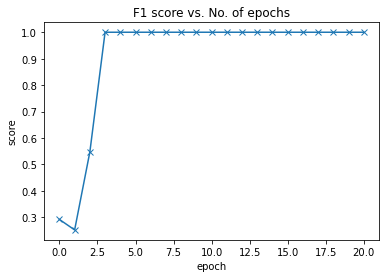

In [50]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
    print(scores)
plot_scores(history)


In [56]:
torch.save(model.state_dict(), 'model.pth')

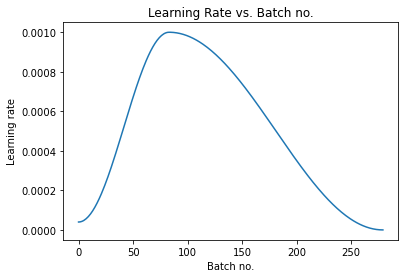

In [57]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

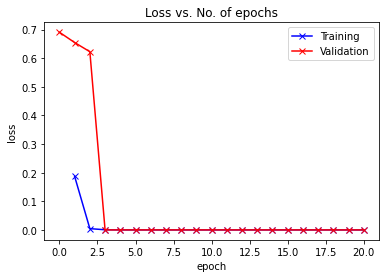

In [58]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

Image Path: Face Recognition/Alvian/132.jpg
Label: Alvian


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor([5.0331e-06, 4.5140e-06, 2.8002e-06, 1.0000e+00],
       grad_fn=<SelectBackward0>)

tensor([5.0331e-06, 4.5140e-06, 2.8002e-06, 1.0000e+00],
       grad_fn=<SelectBackward0>)


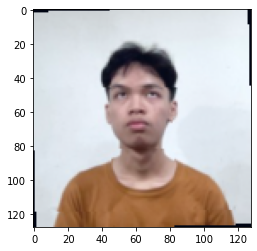

In [59]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_examples(image, prediction)
predict_single(validation_datasplit[84][0])